# VAE Version (AI Lab Run)
- V2: inheriting from A-V10, that we have attention module, as well as biLSTM. Now we also add VAE. 

## Preparing

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_sequence
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from model_model import VAENetV1 as TheLearner
from model_dataset import DS_Tools
from model_dataset import WordDataset as ThisDataset
from model_dataset import Normalizer, DeNormalizer, TokenMap
# from model_dataset import MelSpecTransformDB as TheTransform
from model_dataset import MelSpecTransformDB as TheTransform
from paths import *
from misc_my_utils import *
from misc_recorder import *
from model_loss import *
from model_padding import generate_mask_from_lengths_mat

### Dirs

In [3]:
rec_dir = train_cut_word_
train_guide_path = os.path.join(src_, "guide_train.csv")
valid_guide_path = os.path.join(src_, "guide_validation.csv")
test_guide_path = os.path.join(src_, "guide_test.csv")

### Constants

In [4]:
BATCH_SIZE = 512

INPUT_DIM = 64
OUTPUT_DIM = 64 

INTER_DIM_0 = 32
INTER_DIM_1 = 16
INTER_DIM_2 = 8

ENC_SIZE_LIST = [INPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]
DEC_SIZE_LIST = [OUTPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]

DROPOUT = 0.5

REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64

NUM_LAYERS = 5

LOADER_WORKER = 32
# LOADER_WORKER = 0

## Prepare for this time of training

In [5]:
ts = str(get_timestamp())
# ts = "0218162227"
stop_epoch = "29"
train_name = "B_02"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
mk(model_save_dir)
print(f"{train_name}-{ts}")

train_losses = ListRecorder(os.path.join(model_save_dir, "train.loss"))
valid_losses = ListRecorder(os.path.join(model_save_dir, "valid.loss"))

train_recon_losses = ListRecorder(os.path.join(model_save_dir, "train.recon.loss"))
valid_recon_losses = ListRecorder(os.path.join(model_save_dir, "valid.recon.loss"))

train_kl_losses = ListRecorder(os.path.join(model_save_dir, "train.kl.loss"))
valid_kl_losses = ListRecorder(os.path.join(model_save_dir, "valid.kl.loss"))

train_accs = ListRecorder(os.path.join(model_save_dir, "train.acc"))
valid_accs = ListRecorder(os.path.join(model_save_dir, "valid.acc"))
text_hist = HistRecorder(os.path.join(model_save_dir, "trainhist.txt"))

B_02-0218171336


- 0217175750: first trial of training. 
- 0217195946: take the opposite of kl to turn it into loss, instead of divergence. [!!! This is wrong]
- 0217200818: add num layers to 3. 
- 0218162227: This time we increase the weighting of KL divergence in training and check whether that will make hidden representation learning better. In addition, we also increase LSTM layer to 5. 
- 0218171336: this time make beta = 1.5

In [6]:
READ = False
DATAREAD = False

In [7]:
with open(os.path.join(src_, "no-stress-seg.dict"), "rb") as file:
    # Load the object from the file
    mylist = pickle.load(file)
    mylist = ["BLANK"] + mylist

# Now you can use the loaded object
mymap = TokenMap(mylist)

mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, 
                       n_fft=N_FFT, n_mels=N_MELS, 
                       normalizer=Normalizer.norm_mvn, 
                       denormalizer=DeNormalizer.norm_mvn)

train_ds = ThisDataset(rec_dir, 
                       train_guide_path, 
                       mapper=mymap, 
                       transform=mytrans)
valid_ds = ThisDataset(rec_dir, 
                       valid_guide_path, 
                       mapper=mymap, 
                       transform=mytrans)

use_proportion = 0.3

if READ or DATAREAD: 
    train_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "train.use"))
    valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid.use"))

    use_train_ds = torch.utils.data.Subset(train_ds, train_ds_indices)
    use_valid_ds = torch.utils.data.Subset(valid_ds, valid_ds_indices)
else: 
    # train data
    use_len = int(use_proportion * len(train_ds))
    remain_len = len(train_ds) - use_len
    use_train_ds, remain_ds = random_split(train_ds, [use_len, remain_len])

    # valid data
    use_len = int(use_proportion * len(valid_ds))
    remain_len = len(valid_ds) - use_len
    use_valid_ds, remain_ds = random_split(valid_ds, [use_len, remain_len])

    # NOTE: we don't need to save the cut-small subset, because after cutting-small, 
    # the saved train and valid separations will reflect this
    DS_Tools.save_indices(os.path.join(model_save_dir, "train.use"), use_train_ds.indices)
    DS_Tools.save_indices(os.path.join(model_save_dir, "valid.use"), use_valid_ds.indices)

train_loader = DataLoader(use_train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(use_valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
valid_num = len(valid_loader.dataset)

In [8]:
train_num, valid_num, len(train_loader), len(valid_loader)

(231830, 31142, 453, 61)

torch.Size([512, 73, 64])


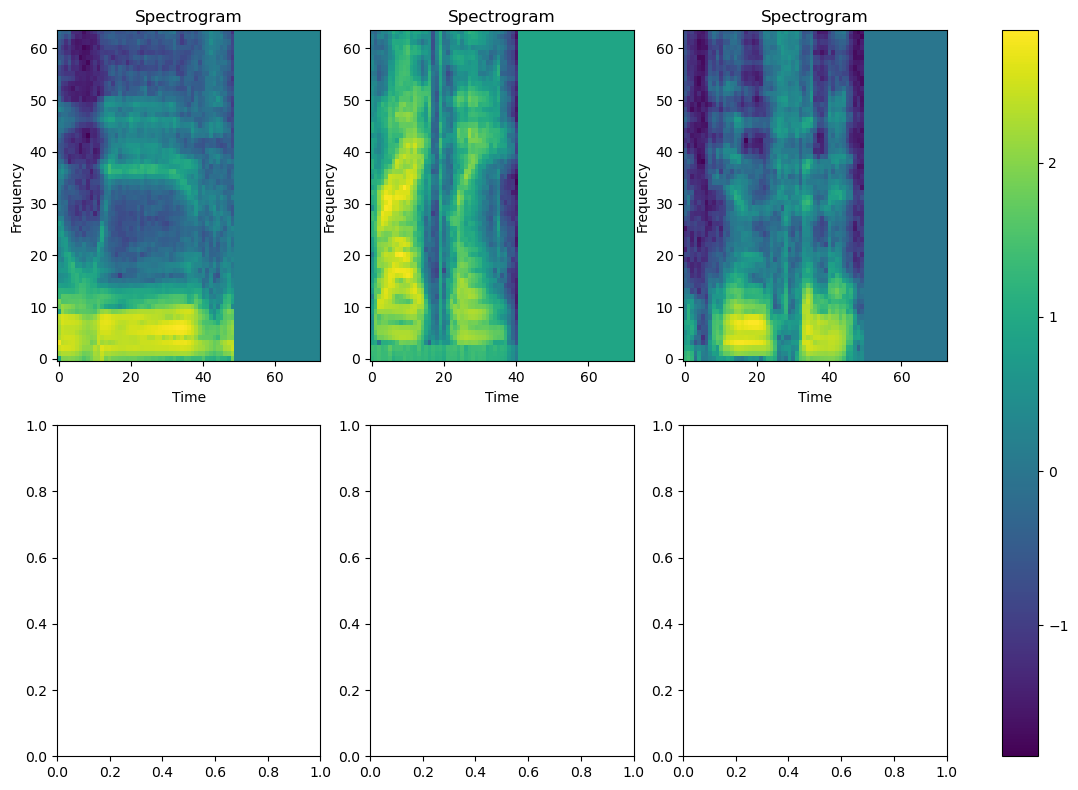

In [9]:
# Load sample data from train_loader
sample_data = next(iter(valid_loader))
xx_pad, x_lens = sample_data
print(xx_pad.shape)
# Set the random seed for reproducibility
# random.seed(101)
# Generate six random indices
# random_indices = random.sample(range(len(xx_pad)), 6)
random_indices = list(range(6, 9))

# Plot the spectrograms and mark the corresponding seg
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    spectrogram = xx_pad[idx]
    
    ax = axes[i]
    img = ax.imshow(spectrogram.T, aspect='auto', origin="lower")
    ax.set_title(f'Spectrogram')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')

# for i, idx in enumerate(random_indices):
#     spectrogram = masked_xx_pad[idx]
    
#     ax = axes[i + 3]
#     img = ax.imshow(spectrogram.T, aspect='auto', origin="lower")
#     ax.set_title(f'Spectrogram')
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Frequency')
plt.tight_layout()
plt.colorbar(img,ax=axes)
plt.show()

## Loss
VAE的损失由重构损失和KL损失组成.

KL散度就不再推导了, 直接放结果:
$$KL\Big(N(\mu,\sigma^2)\Big\Vert N(0,1)\Big)=\frac{1}{2}\Big(-\log \sigma^2+\mu^2+\sigma^2-1\Big)$$

VAE的目标是最小化$Z$和$\mathcal{N}(0, I)$之间的KL散度, 代码只需要照着写就行了:

In [10]:
kl_loss = MaskedKLDivLoss()
recon_loss = MaskedLoss(loss_fn=nn.MSELoss(reduction="none"))

## Prepare Model
先定义好训练的epoch和batch_size, 优化器随便选一个世界上最好的优化器Adam(lr=1e-3):

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TheLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=NUM_LAYERS, dropout=DROPOUT)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_str = str(model)
model_txt_path = os.path.join(model_save_dir, "model.txt")

with open(model_txt_path, "w") as f:
    f.write(model_str)

In [12]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

# initialize model weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.orthogonal_(m.weight)
        m.bias.data.fill_(0.01)
    if isinstance(m, nn.LSTM): 
        for name, p in m.named_parameters():
            if "weight" in name: 
                nn.init.orthogonal_(p)
            elif "bias" in name: 
                nn.init.constant_(p, 0)

model.apply(init_weights)

17496


VAENetV1(
  (encoder): VAEEncoderV1(
    (lin_1): Linear(in_features=64, out_features=8, bias=True)
    (rnn): LSTM(8, 8, num_layers=5, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (decoder): VAEDecoderV1(
    (rnn): LSTM(8, 8, num_layers=5, batch_first=True, dropout=0.5, bidirectional=True)
    (lin_2): Linear(in_features=16, out_features=64, bias=True)
  )
  (mu_lin): Linear(in_features=16, out_features=8, bias=True)
  (logvar_lin): Linear(in_features=16, out_features=8, bias=True)
)

### Load model if READ

In [13]:
if READ: 
    train_losses.read()
    valid_losses.read()

    train_kl_losses.read()
    valid_kl_losses.read()

    model_name = "{}.pt".format(stop_epoch)
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)

    model.load_state_dict(state)
    model.to(device)

## Training

In [14]:
EPOCHS = 30
BASE = 0

beta = 1.5

In [15]:
for epoch in range(BASE, BASE + EPOCHS):
    text_hist.print("Epoch {}".format(epoch))

    model.train()
    train_loss = 0.
    train_recon_loss = 0.
    train_kl_loss = 0.
    train_num = len(train_loader)    # train_loader
    for idx, (x, x_lens) in enumerate(train_loader):
        # y_lens should be the same as x_lens
        optimizer.zero_grad()
        x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
        # autoencoder
        y = x
        x = x.to(device)
        y = y.to(device)

        x_hat, (mu, logvar) = model(x, x_lens)

        recon = recon_loss.get_loss(x_hat, y, x_mask)
        kl = kl_loss.get_loss(mu, logvar, x_mask)
        loss = recon + beta * kl    # elbo

        train_loss += loss.item()
        train_recon_loss += recon.item()
        train_kl_loss += kl.item()

        loss.backward()
        # torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=5, norm_type=2)
        optimizer.step()

        if idx % 100 == 0:
            text_hist.print(f"Training loss {loss: .3f} \t Recon {recon: .3f} \t KL {kl: .3f} in Step {idx}")

    train_losses.append(train_loss / train_num)
    train_recon_losses.append(train_recon_loss / train_num)
    train_kl_losses.append(train_kl_loss / train_num)
    text_hist.print(f"※※※Training loss {train_loss / train_num: .3f}※※※")

    last_model_name = "{}.pt".format(epoch)
    torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))


    model.eval()
    valid_loss = 0.
    valid_recon_loss = 0.
    valid_kl_loss = 0.
    valid_num = len(valid_loader)
    for idx, (x, x_lens) in enumerate(valid_loader):
        x_mask = generate_mask_from_lengths_mat(x_lens, device=device)

        y = x
        x = x.to(device)
        y = y.to(device)

        x_hat, (mu, logvar) = model(x, x_lens)

        recon = recon_loss.get_loss(x_hat, y, x_mask)
        kl = kl_loss.get_loss(mu, logvar, x_mask)
        loss = recon + beta * kl    # elbo

        valid_loss += loss.item()
        valid_recon_loss += recon.item()
        valid_kl_loss += kl.item()

    text_hist.print(f"Valid loss {valid_loss / valid_num: .3f} \t Recon {valid_recon_loss / valid_num: .3f} \t KL {valid_kl_loss / valid_num: .3f}")
    valid_losses.append(valid_loss / valid_num)
    valid_recon_losses.append(valid_recon_loss / valid_num)
    valid_kl_losses.append(valid_kl_loss / valid_num)

Epoch 0
Training loss  1.001 	 Recon  1.000 	 KL  0.001 in Step 0
Training loss  0.778 	 Recon  0.778 	 KL  0.000 in Step 100
Training loss  0.789 	 Recon  0.789 	 KL  0.000 in Step 200
Training loss  0.764 	 Recon  0.764 	 KL  0.000 in Step 300
Training loss  0.749 	 Recon  0.749 	 KL  0.000 in Step 400
※※※Training loss  0.779※※※
Valid loss  0.727 	 Recon  0.727 	 KL  0.000
Epoch 1
Training loss  0.731 	 Recon  0.731 	 KL  0.000 in Step 0
Training loss  0.725 	 Recon  0.725 	 KL  0.000 in Step 100
Training loss  0.716 	 Recon  0.716 	 KL  0.000 in Step 200
Training loss  0.709 	 Recon  0.709 	 KL  0.000 in Step 300
Training loss  0.715 	 Recon  0.715 	 KL  0.000 in Step 400
※※※Training loss  0.717※※※
Valid loss  0.720 	 Recon  0.720 	 KL  0.000
Epoch 2
Training loss  0.703 	 Recon  0.703 	 KL  0.000 in Step 0
Training loss  0.729 	 Recon  0.729 	 KL  0.000 in Step 100
Training loss  0.714 	 Recon  0.713 	 KL  0.000 in Step 200
Training loss  0.707 	 Recon  0.707 	 KL  0.000 in Step 30

觉得Loss位数保留太多的可以自己设置.

下面画出训练过程中训练集和验证集上的损失曲线:

Text(0.5, 1.0, 'Learning Curve')

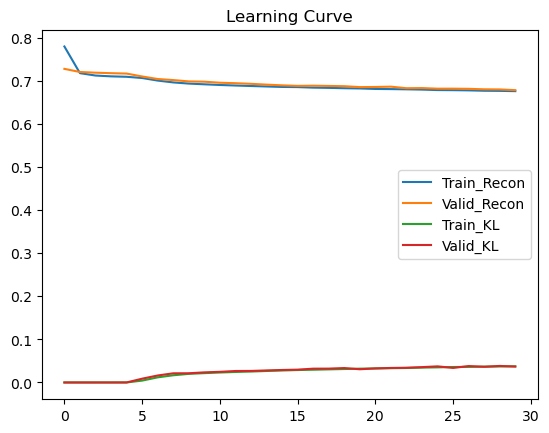

In [16]:
plt.plot(train_losses.get(), label='Train_Recon')
plt.plot(valid_losses.get(), label='Valid_Recon')
plt.plot(train_kl_losses.get(), label='Train_KL')
plt.plot(valid_kl_losses.get(), label='Valid_KL')
plt.legend()
plt.title('Learning Curve')

In [17]:
ts

'0218171336'

基本上Valid Loss稳定了(其实还有下降空间). 同时要保存在验证集上结果最好的模型, 因为等会还要用最好的模型做生成.